# PyLTR deltaBTimeSeries (Parallel) Demonstration
------------------------------

In [15]:
# this SHOULD work inside JupyterLab if the Python environment is correct
#%matplhttp://localhost:8889/notebooks/examples/deltaB_IPyParallel.ipynb#otlib widget

# this does NOT work inside JupyterLab, but DOES in a Notebook (less insecure)
%matplotlib notebook

# this should work anywhere
# %matplotlib inline

In [16]:
# import built-in Python libraries

# import common Python packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray
import datetime

In [17]:
# import home-built packages
import pyLTR

In [18]:
# set up Cartopy to plot nice maps
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

scale = '10m'
land = cfeature.NaturalEarthFeature('physical', 'land', scale,
                                    edgecolor='face',
                                    facecolor=cfeature.COLORS['land'])
coast = cfeature.NaturalEarthFeature(category='physical', scale=scale,
                                     edgecolor='k',
                                     facecolor='none', name='coastline')
ocean = cfeature.NaturalEarthFeature(
        category='physical',
        name='ocean',
        scale=scale,
        facecolor=cfeature.COLORS['water'])
rivers = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale=scale,
        facecolor=cfeature.COLORS['water'],
        edgecolor='face')
lakes = cfeature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale=scale,
        facecolor=cfeature.COLORS['water'],
        edgecolor='face')
states = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale=scale,
        facecolor='none',
        edgecolor='k')
countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale=scale,
        facecolor='none',
        edgecolor='k')

def symlog(x):
    """Returns the symmetric log10 value, allowing for negatives"""
    if np.any(np.abs(x) <= 1):
        print("Warning: log values between -1 and 1 flip the sign.")
    return np.sign(x) * np.log10(np.abs(x))

# Create the colormap RGB scale
# cmap_name = 'BinaryRedGreen'
cm_RedGreen = mpl.colors.LinearSegmentedColormap.from_list('BinaryRedGreen',
                                                           [(1, 0, 0), (0, 1, 0)], N=2)

def log_scale_vectors(x, y, scale=np.log10):
    mag = np.sqrt(x*x + y*y)
    angle = np.arctan2(y, x)
    
    mag_scaled = scale(mag)
    mag_scaled[mag_scaled < 0] = 0
    return (mag_scaled*np.cos(angle), mag_scaled*np.sin(angle))

## Runtime Configuration

In [19]:
# set configuration parameters

# folder with outputs
# NOTE: If using a relative path, this path must be wrt where the IPython
#       kernel is running. This may be different for a given cell in this
#       notebook and the kernel used by IPyParallel if the user is not
#       careful. It is probably better to just use absolute paths.
#
#path = '/glade/scratch/jrigler/LTR/2015Mar17/'
#path = '/glade/scratch/ldong/LTR/2015SP/'
path = '/Users/erigler/Devel/Python/pyLTR/examples/data/models/2015StP/'

# prefix for output files
#run = '2015Mar17'
run = '2015SP'

# start time and endtime for processing
t0 = datetime.datetime(2015,3,17,6,0,0)
t1 = datetime.datetime(2015,3,17,6,9,0)

# output folder (this must be relative to path)
#outPath = "../../../jrigler/LTR/13SPB/output/"
outPath = "./"


In [20]:
# Define observatory list 
# (these are real locations for synthetic observatories)

obs = {}

obs['BOU'] = {'name':'Boulder',             'geoLatitude':40.14, 'geoLongitude':254.76}
obs['BRW'] = {'name':'Barrow',              'geoLatitude':71.32, 'geoLongitude':203.38}
obs['BSL'] = {'name':'Stennis Space Center','geoLatitude':30.35, 'geoLongitude':270.37}

obs['CMO'] = {'name':'College',             'geoLatitude':64.87, 'geoLongitude':212.14}
obs['DED'] = {'name':'Deadhorse',           'geoLatitude':70.36, 'geoLongitude':211.21}
obs['FRD'] = {'name':'Fredricksburg',       'geoLatitude':38.20, 'geoLongitude':282.63}

obs['FRN'] = {'name':'Fresno',              'geoLatitude':37.09, 'geoLongitude':240.28}
obs['GUA'] = {'name':'Guam',                'geoLatitude':13.59, 'geoLongitude':144.87}
obs['HON'] = {'name':'Honolulu',            'geoLatitude':21.32, 'geoLongitude':202.00}

obs['NEW'] = {'name':'Newport',             'geoLatitude':48.27, 'geoLongitude':242.88}
obs['SHU'] = {'name':'Shumagin',            'geoLatitude':55.35, 'geoLongitude':199.54}
obs['SIT'] = {'name':'Sitka',               'geoLatitude':57.06, 'geoLongitude':224.67}

obs['SJG'] = {'name':'San Juan',            'geoLatitude':18.11, 'geoLongitude':293.85}
obs['TUC'] = {'name':'Tucson',              'geoLatitude':32.17, 'geoLongitude':249.27}


obs['BLC'] = {'name':'Baker Lake',          'geoLatitude':64.30, 'geoLongitude':264.00}
obs['BRD'] = {'name':'Brandon',             'geoLatitude':49.60, 'geoLongitude':262.90}
obs['HAD'] = {'name':'Hartland',            'geoLatitude':51.00, 'geoLongitude':355.00}

obs['HER'] = {'name':'Hermanus',            'geoLatitude':-34.40, 'geoLongitude':19.20}
obs['IQA'] = {'name':'Iqaluit',             'geoLatitude':63.80, 'geoLongitude':291.50}
obs['KAK'] = {'name':'Kakioka',             'geoLatitude':36.20, 'geoLongitude':140.20}

obs['MEA'] = {'name':'Meanook',             'geoLatitude':54.60, 'geoLongitude':246.70}
obs['OTT'] = {'name':'Ottowa',              'geoLatitude':45.40, 'geoLongitude':284.50}
obs['RES'] = {'name':'Resolute Bay',        'geoLatitude':74.70, 'geoLongitude':265.10}

obs['STJ'] = {'name':'Saint John\'s',       'geoLatitude':47.60, 'geoLongitude':307.30}
obs['VIC'] = {'name':'Victoria',            'geoLatitude':48.60, 'geoLongitude':236.60}
obs['YKC'] = {'name':'Yellow Knife',        'geoLatitude':62.40, 'geoLongitude':245.50}

# create list of lists of observatory coordinates to pass to detlaBTimeSeries.py
obsList = [[elem[1]['geoLongitude']*np.pi/180,
           (90-elem[1]['geoLatitude'])*np.pi/180,
           6378000,
           elem[0]]
           for elem in obs.items()]

In [21]:
# define list of gridded locations at which to calculate ground deltaB
lons, lats = np.meshgrid(np.linspace(-170,-30,71), np.linspace(80,20,31) )
gridList = [[lons.flat[i] * np.pi/180,
             (90 - lats.flat[i]) * np.pi/180,
             6378000]
             for i in range(lons.size)]

In [22]:
# define list of gridded locations at which to calculate ground deltaB
lons, lats = np.meshgrid(np.mod(np.linspace(0,360,181), 360), np.linspace(88,8,41) )
gridList = [[lons.flat[i] * np.pi/180,
             (90 - lats.flat[i]) * np.pi/180,
             6378000]
             for i in range(lons.size)]

## (IPy)Parallel Processing

Break up the time series into time chunks, then use IPyParallel to run deltaBTimeSeries in an "embarassingly parallel" mode. We could use a try-except here, but it's better to have the traceback as a clear indication that something went wrong.

> Note  1: to use ipyparallel, we must set up parallel engines *before* starting IPython/
>          Notebook; also, since it is not easy to guarantee two logins on the same NCAR
>          super node, these engines must be run (and optionally logged) in the background
>          (with modern (2019) Jupyter Notebooks, and with ipyparallel package available,
>           it seems like one can do this via the `IPython Clusters` tab on Notebook's
>           dashboard):
>
> `ipcluster start -n 4 > ipyparallel_20170419.log 2>&1 &`


 ***Generate deltaBTimeSeries at obsList locations***

In [11]:
import ipyparallel

# initialization ipyparallel client and create "direct view"
client = ipyparallel.Client()
dview = client[:]

# generate a list of datetimes to process
tAll = [t0 + datetime.timedelta(minutes=delta_min) 
        for delta_min in range(int((t1 - t0).total_seconds() // 60 + 1))]

# Break up time interval into chunks for parallel processing
nprocs = len(dview)
t0s, t1s = np.transpose([[arr[0], arr[-1]]
                         for arr in np.array_split(tAll, nprocs)])



# construct list of argument dictionaries
args = [{'path':path, 
         'run':run,
         't0':t0s[i],
         't1':t1s[i],
         'obsList':obsList,
         'geoGrid':True,
         'ignoreBinary':False,
         'binaryType':'pkl',
         'outDirName':outPath + '/obs'}
        for i in range(len(t0s))]

# Use deltaBTimeSeries to generate synthetic geomagnetic observations
def mappable_dBextract(kwargs):
    """mappable wrapper to unpack kwargs and pass to dBextract"""
    return pyLTR.Tools.deltaBTimeSeries.extractQuantities(**kwargs)

# Use ipyparallel %magic function to import pyLTR into the engines
%px import pyLTR

# run in parallel
results = dview.map_sync(mappable_dBextract, args)

 ***Generate deltaBTimeSeries at gridList locations***

In [17]:
import ipyparallel

# initialization ipyparallel client and create "direct view"
client = ipyparallel.Client()
dview = client[:]

# generate a list of datetimes to process
tAll = [t0 + datetime.timedelta(minutes=delta_min) 
        for delta_min in range(int((t1 - t0).total_seconds() // 60 + 1))]

# Break up time interval into chunks for parallel processing
nprocs = len(dview)
t0s, t1s = np.transpose([[arr[0], arr[-1]]
                         for arr in np.array_split(tAll, nprocs)])

# construct list of argument dictionaries
args = [{'path':path, 
         'run':run,
         't0':t0s[i],
         't1':t1s[i],
         'obsList':gridList,
         'geoGrid':True,
         'ignoreBinary':False,
         'binaryType':'pkl',
         'outDirName':outPath + '/grid'}
        for i in range(len(t0s))]

# Use deltaBTimeSeries to generate synthetic geomagnetic observations
def mappable_dBextract(kwargs):
    """mappable wrapper to unpack kwargs and pass to dBextract"""
    return pyLTR.Tools.deltaBTimeSeries.extractQuantities(**kwargs)

# Use ipyparallel %magic function to import pyLTR into the engines
%px import pyLTR

# run in parallel
results = dview.map_sync(mappable_dBextract, args)

# Serial Processing

Ideally, this block would simply collate the IPyParallel results chronologically, which should be a fairly trivial operation. If the IPyParallel block failed for any reason, deltaBTimeSeries will be run in serial.

In [33]:
# run deltaBTimeSeries on obsList again to read in all the pkl files generated
# previously and collate them chronologically
dBTSextract = pyLTR.Tools.deltaBTimeSeries.extractQuantities
dBobs = dBTSextract(**{
    'path':path, 
    'run':run,
    't0':t0,
    't1':t1,
    'obsList':obsList,
    'geoGrid':True,
#     'smGrid':False,  # fix so that smGrid is default ONLY if nothing else is set
    'mix':False,
    'tie':True,
    'lfm':True,
    'mix_bs_mx':True,
    'tie_bs_mx':True,
    'ignoreBinary':False,
    'binaryType':'pkl',
    'outDirName':outPath + '/obs'
})


MIX files missing or ignored; continuing anyway...
Extracting quantities for 10 time steps.
Likely not a run from terminal so no progress bar

Pre-compute TIEGCM DALECS
ionospheric currents
Initializing  7760  type1 Bostrom loops
Initializing  7760  type2 Bostrom loops
field-aligned currents
Initializing  7760  type1 Bostrom loops
Initializing  7760  type2 Bostrom loops
...done after 26.374226 seconds

Pre-compute LFM grid and volumes
...done after 0.197943 seconds

Starting main loop
No valid binary file found, recalculating obs_deltaB_2015-03-17T06-00-00Z...

TIEGCM
Calculating BS matrices
Calculating BS matrices
...done after 151.429494 seconds

LFM
...done after 1.088976 seconds
No valid binary file found, recalculating obs_deltaB_2015-03-17T06-01-00Z...

TIEGCM
...done after 0.001659 seconds

LFM
...done after 1.060553 seconds
No valid binary file found, recalculating obs_deltaB_2015-03-17T06-02-00Z...

TIEGCM
...done after 0.001806 seconds

LFM
...done after 1.103824 seconds
No v

In [26]:
# Plot the time series
plt.figure(figsize=(10,12))
for i,obs in enumerate(dBobs):
    plt.subplot(len(dBobs) / 2, 2, i+1)
    plt.plot(obs['dBTot']['datetime']['data'],
             obs['dBTot']['North']['data'])
    plt.plot(obs['dBTot']['datetime']['data'],
             obs['dBTot']['East']['data'])
    plt.plot(obs['dBTot']['datetime']['data'],
             obs['dBTot']['Down']['data'])
    plt.ylabel(obs['dBTot']['obs']['name'])
    plt.gca().yaxis.set_label_position('right')
    plt.gca().set_xticklabels('')
    
    if i+1 == len(dBobs) or i+1 == len(dBobs)-1:
        plt.gca().clear()
        plt.plot(obs['dBTot']['datetime']['data'],
                 obs['dBTot']['North']['data'])
        plt.plot(obs['dBTot']['datetime']['data'],
                 obs['dBTot']['East']['data'])
        plt.plot(obs['dBTot']['datetime']['data'],
                 obs['dBTot']['Down']['data'])
        plt.ylabel(obs['dBTot']['obs']['name'])
        plt.gca().yaxis.set_label_position('right')
        
    if i+1 == len(dBobs):
        plt.legend(('North','East','Down'), loc='lower right', prop={'size': 8})
        

<IPython.core.display.Javascript object>

In [9]:
# run deltaBTimeSeries on gridList again to read in all the pkl files generated
# previously and collate them chronologically
dBTSextract = pyLTR.Tools.deltaBTimeSeries.extractQuantities
dBgrid = dBTSextract(**{
    'path':path, 
    'run':run,
    't0':t0,
    't1':t1,
    'obsList':gridList,
    'geoGrid':True,
    'ignoreBinary':False,
    'binaryType':'pkl',
    'outDirName':outPath + '/grid'
})

Extracting quantities for 10 time steps.
Likely not a run from terminal so no progress bar
Initializing type1 Bostrom loops


/Users/erigler/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/io/netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)
/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:1660: RuntimeWarning: divide by zero encountered in double_scalars
  ps[0] = rho_min / np.sin((theta_max+theta_min)/2.)**2.
/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:2990: RuntimeWarning: invalid value encountered in true_divide
  mu = 0.5 * ((beta*beta + beta*gamma + gamma*gamma) / beta )**(3./2.)


Initializing type2 Bostrom loops


/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:1890: RuntimeWarning: divide by zero encountered in double_scalars
  ps[0] = rho_min / np.sin((theta_max+theta_min)/2.)**2.
/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:2065: RuntimeWarning: invalid value encountered in true_divide
  Jrhos = Irhos / dl_perp
/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:2066: RuntimeWarning: invalid value encountered in true_divide
  Jthetas = Ithetas / dl_perp
/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:2067: RuntimeWarning: invalid value encountered in true_divide
  Jphis = Iphis / dl_perp


Initializing type1 Bostrom loops


/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:1674: RuntimeWarning: divide by zero encountered in double_scalars
  ps[0*n+1:1*n+1] = rho_min / np.sin((theta_max+theta_min)/2.)**2.
/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:1681: RuntimeWarning: divide by zero encountered in double_scalars
  ps[1*n+2:2*n+2] = rho_min / np.sin((theta_max+theta_min)/2.)**2.
/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:1829: RuntimeWarning: invalid value encountered in less
  rhos[rhos < rho_min] = rho_min
/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:1565: RuntimeWarning: invalid value encountered in greater_equal
  dtype=type(theta_min)) &
/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:1567: RuntimeWarning: invalid value encountered in less_equal
  dtype=type(theta_max)))
/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:1579: RuntimeWarning: invalid value encountered in greater_equal
  dtype=type(rho_min)) &
/Users/erigler/Devel/Pyth

Initializing type2 Bostrom loops


/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/DALECS.py:1896: RuntimeWarning: divide by zero encountered in double_scalars
  ps[1*n+1] = rho_min / np.sin((theta_max+theta_min)/2.)**2.


Initializing type1 Bostrom loops
Initializing type2 Bostrom loops
Initializing type1 Bostrom loops
Initializing type2 Bostrom loops
Initializing type1 Bostrom loops
Initializing type2 Bostrom loops
Initializing type1 Bostrom loops
Initializing type2 Bostrom loops
No valid binary file found, recalculating obs_deltaB_2015-03-17T06-00-00Z...

Northern MIX



/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/MIXCalcs.py:467: RuntimeWarning: invalid value encountered in true_divide
  1./p.sin(theta[1:-1,:]) )
/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/MIXCalcs.py:479: RuntimeWarning: invalid value encountered in true_divide
  dpsidphi[-1,:] = (p.diff(psi[-2:,:],axis=0) / dphi[-1,:] / p.sin(theta[-1,:]) )
/Users/erigler/Devel/Python/pyLTR/pyLTR/Physics/MIXCalcs.py:480: RuntimeWarning: invalid value encountered in true_divide
  dpsidphi[0,:] = (p.diff(psi[:2,:],axis=0) / dphi[0,:] / p.sin(theta[0,:]) )


5.482325786026195 Scaling ionospheric currents
7.6519514680840075 Copying ION components into object arrays
12.942330237012357 Scaling field-aligned currents
15.092213332070969 Copying FAC components into object arrays

Southern MIX

20.531784033053555 Scaling ionospheric currents
22.66408025205601 Copying ION components into object arrays
28.008007787982933 Scaling field-aligned currents
30.2161194330547 Copying FAC components into object arrays

MIX DeltaB

40.26202192297205 Northern ionospheric currents Biot-Savart
323.8929928400321 Northern field-aligned currents Biot-Savart
334.1987440499943 Southern ionospheric currents Biot-Savart
622.4532991710585 Southern field-aligned currents Biot-Savart

TIEGCM

Discarding  3888  of  7857 TIEGCM points outside +/- 30 degrees lat.
624.4479564570356 Scaling TIEGCM ionospheric currents
625.1974221540149 Copying ION components into object arrays
627.0660353880376 Scaling TIEGCM field-aligned currents
627.8225726310629 Copying FAC components int

970.3274211130338 LFM magnetosphere Biot-Savart
No valid binary file found, recalculating obs_deltaB_2015-03-17T06-06-00Z...

Northern MIX

6.086451811948791 Scaling ionospheric currents
8.407434029970318 Copying ION components into object arrays
14.20242089801468 Scaling field-aligned currents
16.554461712948978 Copying FAC components into object arrays

Southern MIX

22.524831474991515 Scaling ionospheric currents
24.8073934300337 Copying ION components into object arrays
30.573545666993596 Scaling field-aligned currents
32.95319054904394 Copying FAC components into object arrays

MIX DeltaB

43.265551810967736 Northern ionospheric currents Biot-Savart
342.04666717199143 Northern field-aligned currents Biot-Savart
352.64306842302904 Southern ionospheric currents Biot-Savart
643.45445909095 Southern field-aligned currents Biot-Savart

TIEGCM

Discarding  3888  of  7857 TIEGCM points outside +/- 30 degrees lat.
645.5198465200374 Scaling TIEGCM ionospheric currents
646.2896073249867 Cop

<IPython.core.display.Javascript object>


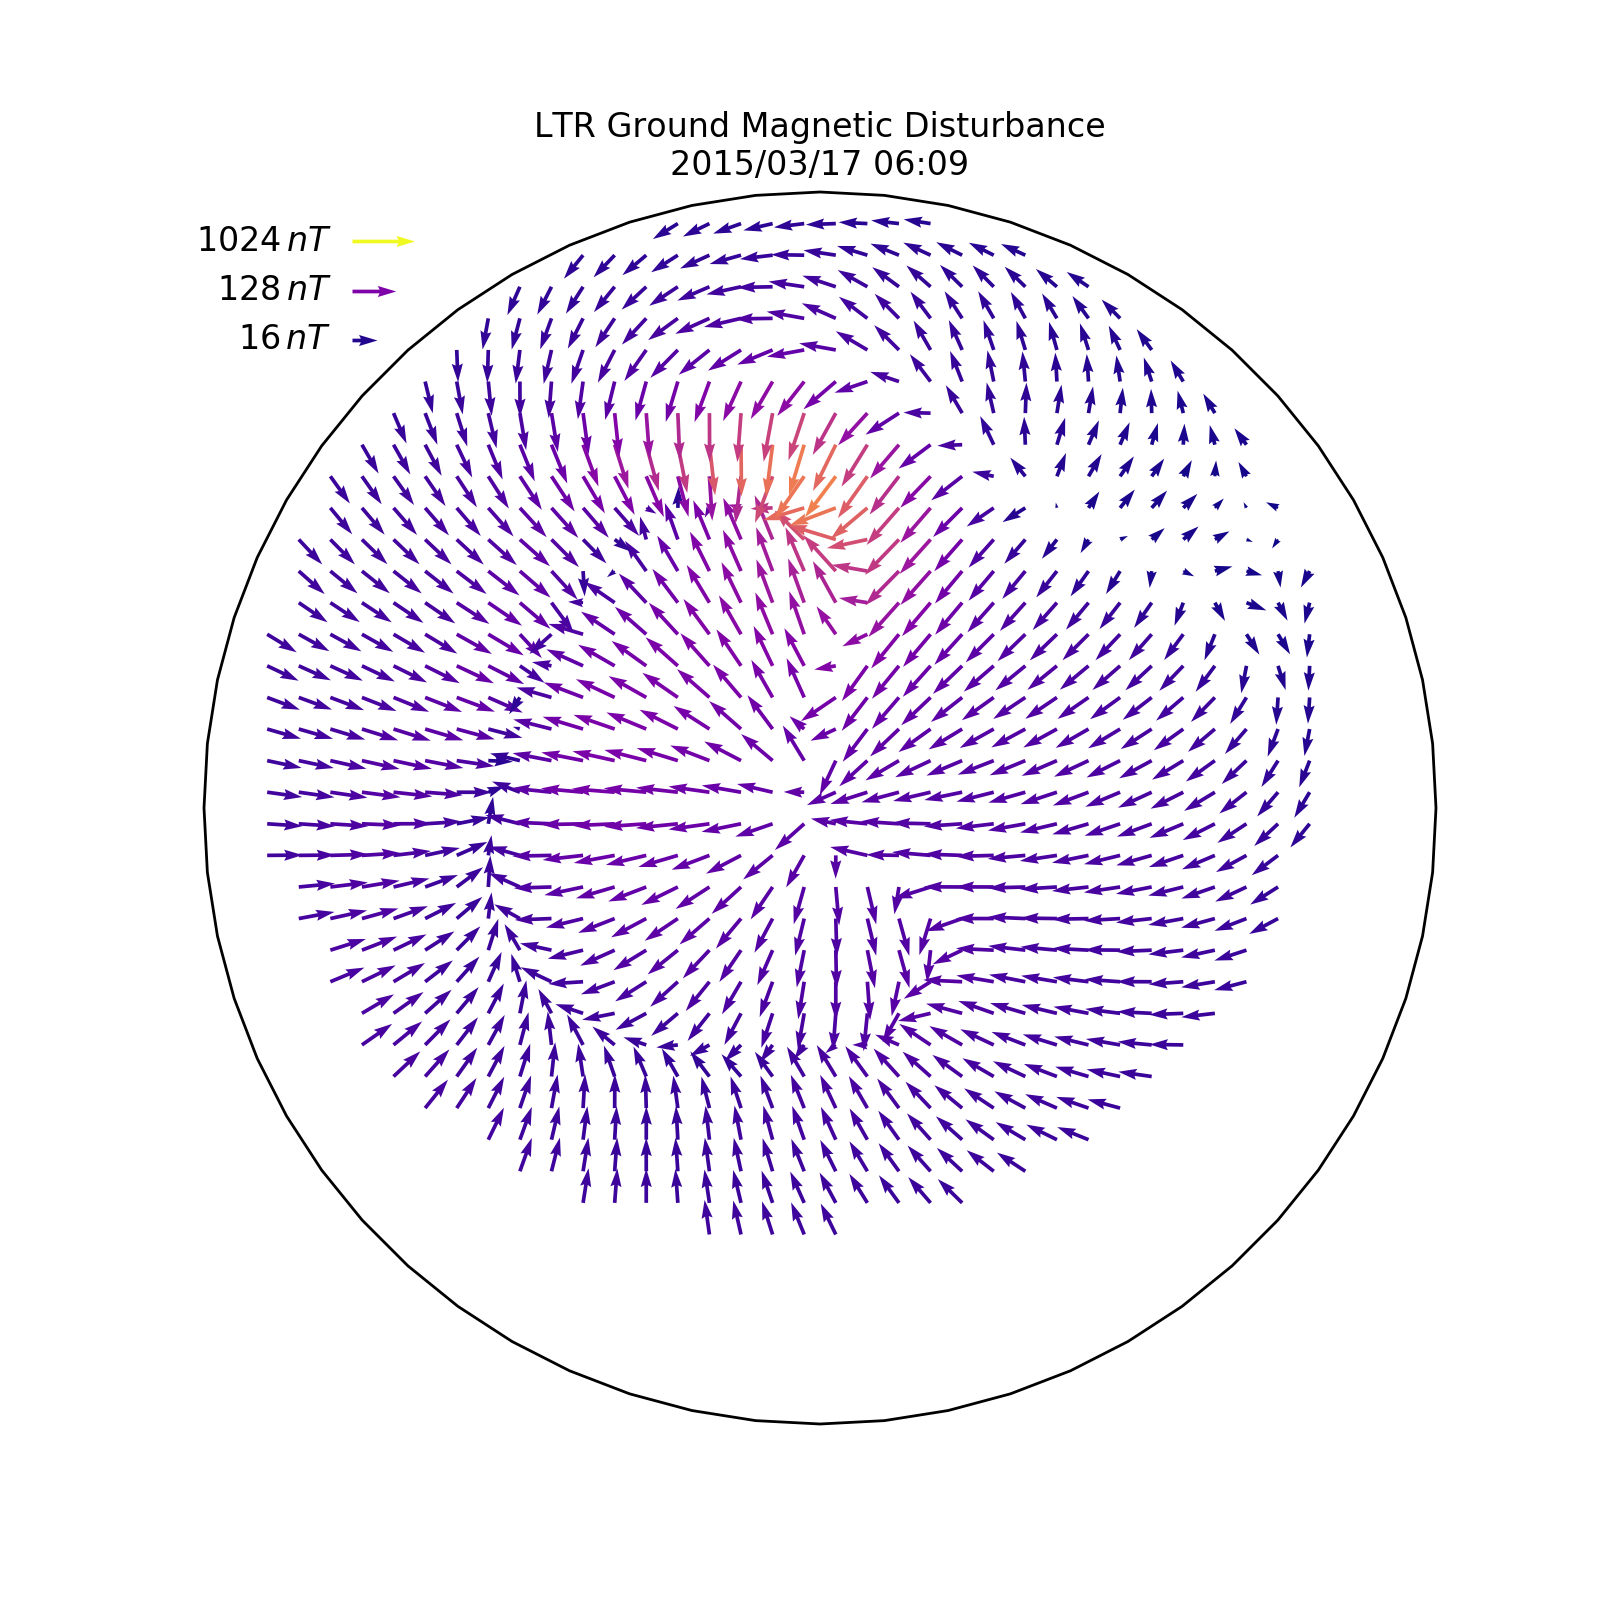

(2534,)


In [45]:
###
### Need to verify that GEO coordinates are correct, the near-polar fields really look
### different than they did when I generated delta-Bs several years ago, then used these
### fields in several presentations since. -EJR
###

# time step index
t = 9

# 
# map config
#
# bbox = [-180, 180, 0, 45]
central_lat = 90
central_lon = 180
#projection = ccrs.Orthographic(central_latitude=central_lat, central_longitude=central_lon)
projection = ccrs.NearsidePerspective(central_latitude=central_lat, 
                                      central_longitude=central_lon,
                                      satellite_height=2500000)
proj_data = ccrs.PlateCarree()

fig, ax_Bfield = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=projection))

#ax_Bfield.set_extent(bbox, proj_data)
#ax_Bfield.add_feature(coast)
#ax_Bfield.add_feature(states, alpha=0.8)
#ax_Bfield.add_feature(countries)


#
# Observatory magnetic disturbance
#
obs_lon = np.array([obs['dBTot']['phiGEO']['data'][t]
                   for obs in dBobs]) * 180 / np.pi
obs_lat = 90 - np.array([obs['dBTot']['thetaGEO']['data'][t]
                         for obs in dBobs]) * 180 / np.pi
obs_rad = np.array([obs['dBTot']['rhoGEO']['data'][t]
                   for obs in dBobs])

obs_Bx = np.array([obs['dBTot']['North']['data'][t]
                   for obs in dBobs])
obs_By = np.array([obs['dBTot']['East']['data'][t]
                   for obs in dBobs])
obs_Bz = np.array([obs['dBTot']['Down']['data'][t]
                   for obs in dBobs])

# # Store the angles for preservation when scaling lengths by logarithms
# B_angles = np.arctan2(obs_Bx, obs_By)

# # NOTE: x is the Northerly component
# uv_mag = np.log10(obs_Bmag+1)
# obs_By_log = uv_mag*np.cos(B_angles)
# obs_Bx_log = uv_mag*np.sin(B_angles)


obs_By_log, obs_Bx_log = log_scale_vectors(obs_By, obs_Bx, scale=np.log2)
obs_Bmag = np.sqrt(obs_Bx**2 + obs_By**2)


Bscale = 32
arrow_width = 0.003
norm = mpl.colors.Normalize(vmin=0, vmax=512)
cmap = mpl.cm.plasma

# Q_obs = ax_Bfield.quiver(obs_lon, obs_lat,
#                  obs_By_log, obs_Bx_log, obs_Bmag, cmap=cmap,
#                  transform=proj_data,
#                  scale_units='inches', scale=Bscale, width=arrow_width,
#                  alpha=1., norm=norm)

# mag_fit_colors = np.ones(len(dBobs))
# mag_fit_colors[~np.all([np.isfinite(obs_Bx),
#                         np.isfinite(obs_By),
#                         np.isfinite(obs_Bz)])] = 0.

# norm_RedGreen = mpl.colors.Normalize(vmin=0, vmax=1)
# obs_scatter = ax_Bfield.scatter(obs_lon, obs_lat,
#                                 c=mag_fit_colors, norm=norm_RedGreen,
#                                 cmap=cm_RedGreen, s=100, alpha=0.75,
#                                 zorder=0, transform=proj_data)

#
# Gridded magnetic disturbance
#
grid_lon = np.array([grid['dBTot']['phiGEO']['data'][t]
                     for grid in dBgrid[::1]]) * 180 / np.pi
grid_lat = 90 - np.array([grid['dBTot']['thetaGEO']['data'][t]
                          for grid in dBgrid[::1]]) * 180 / np.pi
grid_rad = np.array([grid['dBTot']['rhoGEO']['data'][t]
                     for grid in dBgrid[::1]])

grid_Bx = np.array([grid['dBTot']['North']['data'][t]
                   for grid in dBgrid[::1]])
grid_By = np.array([grid['dBTot']['East']['data'][t]
                   for grid in dBgrid[::1]])
grid_Bz = np.array([grid['dBTot']['Down']['data'][t]
                   for grid in dBgrid[::1]])



valid_view = ((grid_lat < 90) &
              (grid_lat > 60) &
              (grid_lon <= 360) &
              (grid_lon >= 0))
grid_lon = grid_lon[valid_view]
grid_lat = grid_lat[valid_view]
grid_rad = grid_rad[valid_view]
grid_Bx = grid_Bx[valid_view]
grid_By = grid_By[valid_view]
grid_Bz = grid_Bz[valid_view]

print(grid_lon.shape)

# !TESTING!
# convert to SM to see if GEO bug goes away
x, y, z, dx, dy, dz = pyLTR.transform.SPHtoCAR(
    grid_lon * np.pi / 180.,
    (90 - grid_lat) * np.pi / 180.,
    6500e3,
    grid_By,
    -grid_Bx,
    -grid_Bz)

time = dBgrid[0]['dBTot']['datetime']['data'][t]
x_sm, y_sm, z_sm = pyLTR.transform.GEOtoSM(x, y, z, time)
dx_sm, dy_sm, dz_sm = pyLTR.transform.GEOtoSM(dx, dy, dz, time)

(phi_TIE_sm, theta_TIE_sm, rho_TIE_sm,
 Jphi_TIE_sm, Jtheta_TIE_sm, Jrho_TIE_sm) = pyLTR.transform.CARtoSPH(
    x_sm, y_sm, z_sm, dx_sm, dy_sm, dz_sm)

grid_lon = phi_TIE_sm * 180/np.pi
grid_lat = 90 - (theta_TIE_sm * 180/np.pi)
grid_rad = rho_TIE_sm
grid_Bx = -Jtheta_TIE_sm
grid_By = Jphi_TIE_sm
grid_Bz = -Jrho_TIE_sm


# # Store the angles for preservation when scaling lengths by logarithms
# B_angles = np.arctan2(grid_Bx, grid_By)

# # NOTE: x is the Northerly component
# uv_mag = np.log10(grid_Bmag+1)
# grid_By_log = uv_mag*np.cos(B_angles)
# grid_Bx_log = uv_mag*np.sin(B_angles)


grid_By_log, grid_Bx_log = log_scale_vectors(grid_By, grid_Bx, scale=np.log2)
grid_Bmag = np.sqrt(grid_Bx**2 + grid_By**2)



Q = ax_Bfield.quiver(grid_lon, grid_lat,
                     grid_By_log, grid_Bx_log, grid_Bmag, cmap=cmap,
                     transform=proj_data,
                     scale_units='inches', scale=Bscale, 
                     norm=norm, width=arrow_width,
                     regrid_shape=40)

cmap = Q.get_cmap()
color = cmap(norm(1024))

qk = ax_Bfield.quiverkey(Q, 0.12, .96, 10, r'$1024\,nT$',
                         labelpos='W', coordinates='axes', zorder=1,
                         color=color,
                         fontproperties={"size": 12})

color = cmap(norm(128))
qk = ax_Bfield.quiverkey(Q, 0.12, .92, 7, r'$128\,nT$',
                         labelpos='W', coordinates='axes', zorder=1,
                         color=color,
                         fontproperties={"size": 12})

color = cmap(norm(16))
qk = ax_Bfield.quiverkey(Q, 0.12, .88, 4, r'$16\,nT$',
                         labelpos='W', coordinates='axes', zorder=1,
                         color=color,
                         fontproperties={"size": 12})

title = ax_Bfield.set_title("LTR Ground Magnetic Disturbance\n{0}".format(
                dBobs[0]['dBTot']['datetime']['data'][t].strftime("%Y/%m/%d %H:%M")))

In [27]:
np.log2(1024)

10.0

In [18]:
# load TIEGCM secondary history (sech) file
path = '/glade/scratch/ldong/LTR/2015SP/'
data_sech = xarray.open_dataset(path+'2015SP_sech_tie_2015-03-16T23-31-00_2015-03-17T00-00-00.nc')

print(data_sech.mlat.values)
print(data_sech.mlon.values)
print(data_sech.time[-1].values)
print(data_sech.KQLAM[-1].values[0,:])
print(data_sech.KQPHI[-1].values[0,:])

[-9.00000000e+01 -8.81238292e+01 -8.62386359e+01 -8.43344383e+01
 -8.24013319e+01 -8.04295345e+01 -7.84094552e+01 -7.63317966e+01
 -7.41876989e+01 -7.19689342e+01 -6.96681589e+01 -6.72792280e+01
 -6.47975707e+01 -6.22206194e+01 -5.95482728e+01 -5.67833601e+01
 -5.39320608e+01 -5.10042204e+01 -4.80134966e+01 -4.49772755e+01
 -4.19163139e+01 -3.88540981e+01 -3.58159498e+01 -3.28279554e+01
 -2.99158267e+01 -2.71038149e+01 -2.44137889e+01 -2.18645574e+01
 -1.94714698e+01 -1.72462862e+01 -1.51972698e+01 -1.33294282e+01
 -1.16448185e+01 -1.01428244e+01 -8.82031765e+00 -7.67162666e+00
 -6.68827298e+00 -5.85851735e+00 -5.16689314e+00 -4.59404694e+00
 -4.11722526e+00 -3.71151171e+00 -3.35148255e+00 -3.01257883e+00
 -2.67136427e+00 -2.30362872e+00 -1.87754944e+00 -1.32687204e+00
 -7.72840966e-08  1.32687204e+00  1.87754944e+00  2.30362872e+00
  2.67136427e+00  3.01257883e+00  3.35148255e+00  3.71151171e+00
  4.11722526e+00  4.59404694e+00  5.16689314e+00  5.85851735e+00
  6.68827298e+00  7.67162

<IPython.core.display.Javascript object>


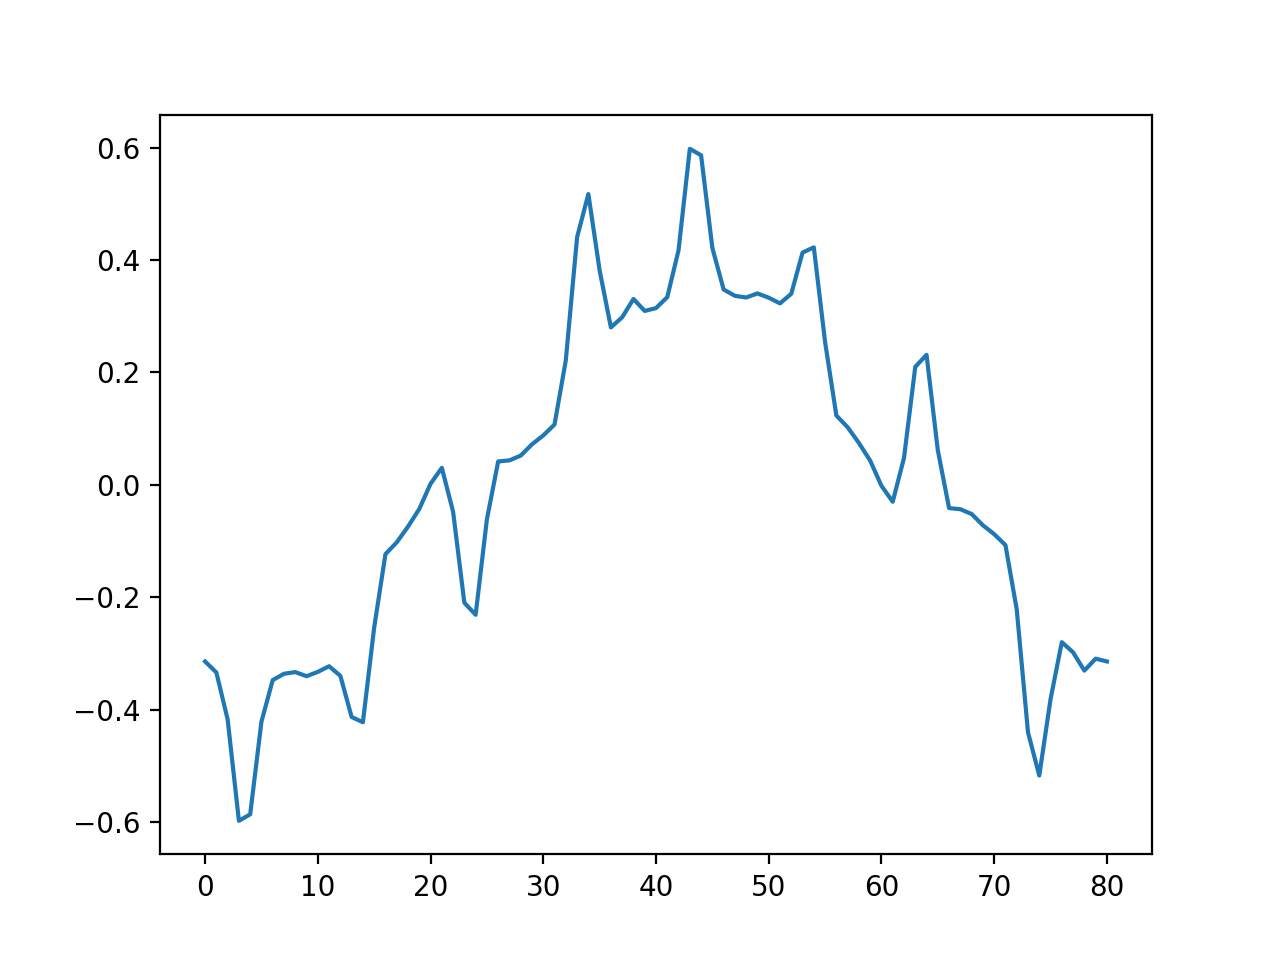

In [15]:
plt.plot(data_sech.KQLAM[-1].values[0,:])

In [13]:
p = np

# create MIX data object
dMIX = pyLTR.Models.MIX(path, run)

# make sure necessary variables are defined in the model.
modelVars = dMIX.getVarNames()
for v in ['Grid X', 'Grid Y',
          'Potential North [V]', 'Potential South [V]',
          'FAC North [A/m^2]', 'FAC South [A/m^2]',
          'Pedersen conductance North [S]', 'Pedersen conductance South [S]',
          'Hall conductance North [S]', 'Hall conductance South [S]',
          'Average energy North [keV]', 'Average energy South [keV]',
          'Number flux North [1/cm^2 s]', 'Number flux South [1/cm^2 s]']:
    assert( v in modelVars )

# create vector of MIX time steps
timeRange = dMIX.getTimeRange()

# basic sanity check(s) before proceeding
if len(timeRange) == 0:
    raise Exception(('No MIX data files found.',
                     'Are you pointing to the correct run directory?'))

# get indices to first and last desired time steps
index0 = 0
if t0:
    for i,t in enumerate(timeRange):
        if t0 >= t:
            index0 = i
index1 = len(timeRange)
if t1:
    for i,t in enumerate(timeRange):
        if t1 >= t:
            index1 = i + 1 
print(( 'Extracting quantities for %d time steps.' % (index1-index0) ))



dTIEGCM = pyLTR.Models.TIEGCM(path, run)

theta_TIE_mag, phi_TIE_mag = p.meshgrid(
    (90 - dTIEGCM.read('mlat', timeRange[index0])) * np.pi/180.,
    dTIEGCM.read('mlon', timeRange[index0]) * np.pi/180.)


Extracting quantities for 2 time steps.


In [14]:
time = timeRange[720]

In [15]:
print(time)

2015-03-17 06:00:00


In [16]:
time = dTIEGCM.getTimeRange()[720]

# retrieve TIEGCM height-integrated currents; drop redundant
# longitudes, convert to GEO coordinates
x, y, z, dx, dy, dz = pyLTR.transform.SPHtoCAR(
    phi_TIE_mag,
    theta_TIE_mag,
    6500e3,
    dTIEGCM.read('KQPHI', time).T,
    -dTIEGCM.read('KQLAM', time).T,
    0.0)

x_sm, y_sm, z_sm = pyLTR.transform.MAGtoSM(x, y, z, time)
dx_sm, dy_sm, dz_sm = pyLTR.transform.MAGtoSM(dx, dy, dz, time)

(phi_TIE_sm, theta_TIE_sm, rho_TIE_sm,
 Jphi_TIE_sm, Jtheta_TIE_sm, Jrho_TIE_sm) = pyLTR.transform.CARtoSPH(
    x_sm, y_sm, z_sm, dx_sm, dy_sm, dz_sm)

print()
print()
print('dTIEGCM.KQPHI.T shape = ', dTIEGCM.read('KQPHI', time).T.shape)
print(dTIEGCM.read('KQPHI', time).T)
print()
print('Jphi_TIE_sm shape = ', Jphi_TIE_sm.shape)
print(Jphi_TIE_sm)
print()
print('-dTIEGCM.KQLAM.T shape = ', dTIEGCM.read('KQLAM', time).T.shape)
print(-dTIEGCM.read('KQLAM', time).T)
print()
print('Jtheta_TIE_sm shape = ', Jtheta_TIE_sm.shape)
print(Jtheta_TIE_sm)

print()
print()
print('phi_TIE_mag shape = ', phi_TIE_mag.shape)
print(phi_TIE_mag * 180/np.pi)
print()
print('theta_TIE_mag shape = ', theta_TIE_mag.shape)
print(theta_TIE_mag * 180/np.pi)
print()
print('phi_TIE_sm shape = ', phi_TIE_sm.shape)
print(phi_TIE_sm * 180/np.pi)
print()
print('theta_TIE_sm shape = ', theta_TIE_sm.shape)
print(theta_TIE_sm * 180/np.pi)




dTIEGCM.KQPHI.T shape =  (81, 97)
[[-0.15803482 -0.09038506  0.00332205 ... -0.08615211 -0.00818252
   0.01122005]
 [-0.13196486 -0.05580788  0.0097415  ... -0.06520383 -0.00159238
   0.01428494]
 [-0.10764475 -0.03143255  0.01080974 ... -0.04010535  0.00396838
   0.01710455]
 ...
 [-0.20288603 -0.148661   -0.02824518 ... -0.11217883 -0.02380559
   0.00680822]
 [-0.17867659 -0.11423099 -0.0085375  ... -0.1017553  -0.01564966
   0.00869138]
 [-0.15803482 -0.09038506  0.00332205 ... -0.08615211 -0.00818252
   0.01122005]]

Jphi_TIE_sm shape =  (81, 97)
[[-0.15803482 -0.09038506  0.00332205 ... -0.08615211 -0.00818252
   0.01122005]
 [-0.13196486 -0.05580788  0.0097415  ... -0.06520383 -0.00159238
   0.01428494]
 [-0.10764475 -0.03143255  0.01080974 ... -0.04010535  0.00396838
   0.01710455]
 ...
 [-0.20288603 -0.148661   -0.02824518 ... -0.11217883 -0.02380559
   0.00680822]
 [-0.17867659 -0.11423099 -0.0085375  ... -0.1017553  -0.01564966
   0.00869138]
 [-0.15803482 -0.09038506  0.00

In [17]:
(rvTIE_ion,
 JvTIE_ion,
 dvTIE_ion) = pyLTR.Physics.DALECS.dalecs_sphere(
    (85*np.pi/180., 44*np.pi/180, 6500e3),
    (95*np.pi/180., 46*np.pi/180, 6500e3),
    (0, 2),
    10,
    False
)

print("rvTIE_ion = ", rvTIE_ion)
print("JvTIE_ion = ", JvTIE_ion)
print("dvTIE_ion = ", dvTIE_ion)

(dBphiTIE_ion,
 dBthetaTIE_ion,
 dBrhoTIE_ion) = pyLTR.Physics.BS.bs_sphere(
    rvTIE_ion,
    JvTIE_ion,
    dvTIE_ion,
    (90*np.pi/180., 45*np.pi/180, 6400e3)
)

print("dBphiTIE_ion = ", dBphiTIE_ion)
print("dBthetaTIE_ion = ", dBthetaTIE_ion)
print("dBrhoTIE_ion = ", dBrhoTIE_ion)

rvTIE_ion =  [array([1.57079633, 1.57079633]), array([0.78539816, 0.78539816]), array([6500000., 6500000.])]
JvTIE_ion =  [array([0., 0.]), array([0., 2.]), array([0., 0.])]
dvTIE_ion =  [1.82010502e+11 1.82010502e+11]
dBphiTIE_ion =  3.6402100300585677e-06
dBthetaTIE_ion =  3.94565658235784e-38
dBrhoTIE_ion =  1.2065674460480464e-36


In [30]:
# retrieve TIEGCM height-integrated currents; drop redundant
# longitudes, convert to GEO coordinates
x, y, z, dx, dy, dz = pyLTR.transform.SPHtoCAR(
    phi_TIE_mag,
    theta_TIE_mag,
    6500e3,
    dTIEGCM.read('KQPHI', time).T,
    -dTIEGCM.read('KQLAM', time).T,
    0.0 )

x, y, z = pyLTR.transform.MAGtoGEO(x, y, z, time)
dx, dy, dz = pyLTR.transform.MAGtoGEO(dx, dy, dz, time)

# x, y, z = pyLTR.transform.GEOtoMAG(x, y, z, time)
# dx, dy, dz = pyLTR.transform.GEOtoMAG(dx, dy, dz, time)

(phi_TIE_geo, theta_TIE_geo, rho_TIE_geo,
 Jphi_TIE_geo, Jtheta_TIE_geo, Jrho_TIE_geo) = pyLTR.transform.CARtoSPH(
    x, y, z, dx, dy, dz)


<IPython.core.display.Javascript object>


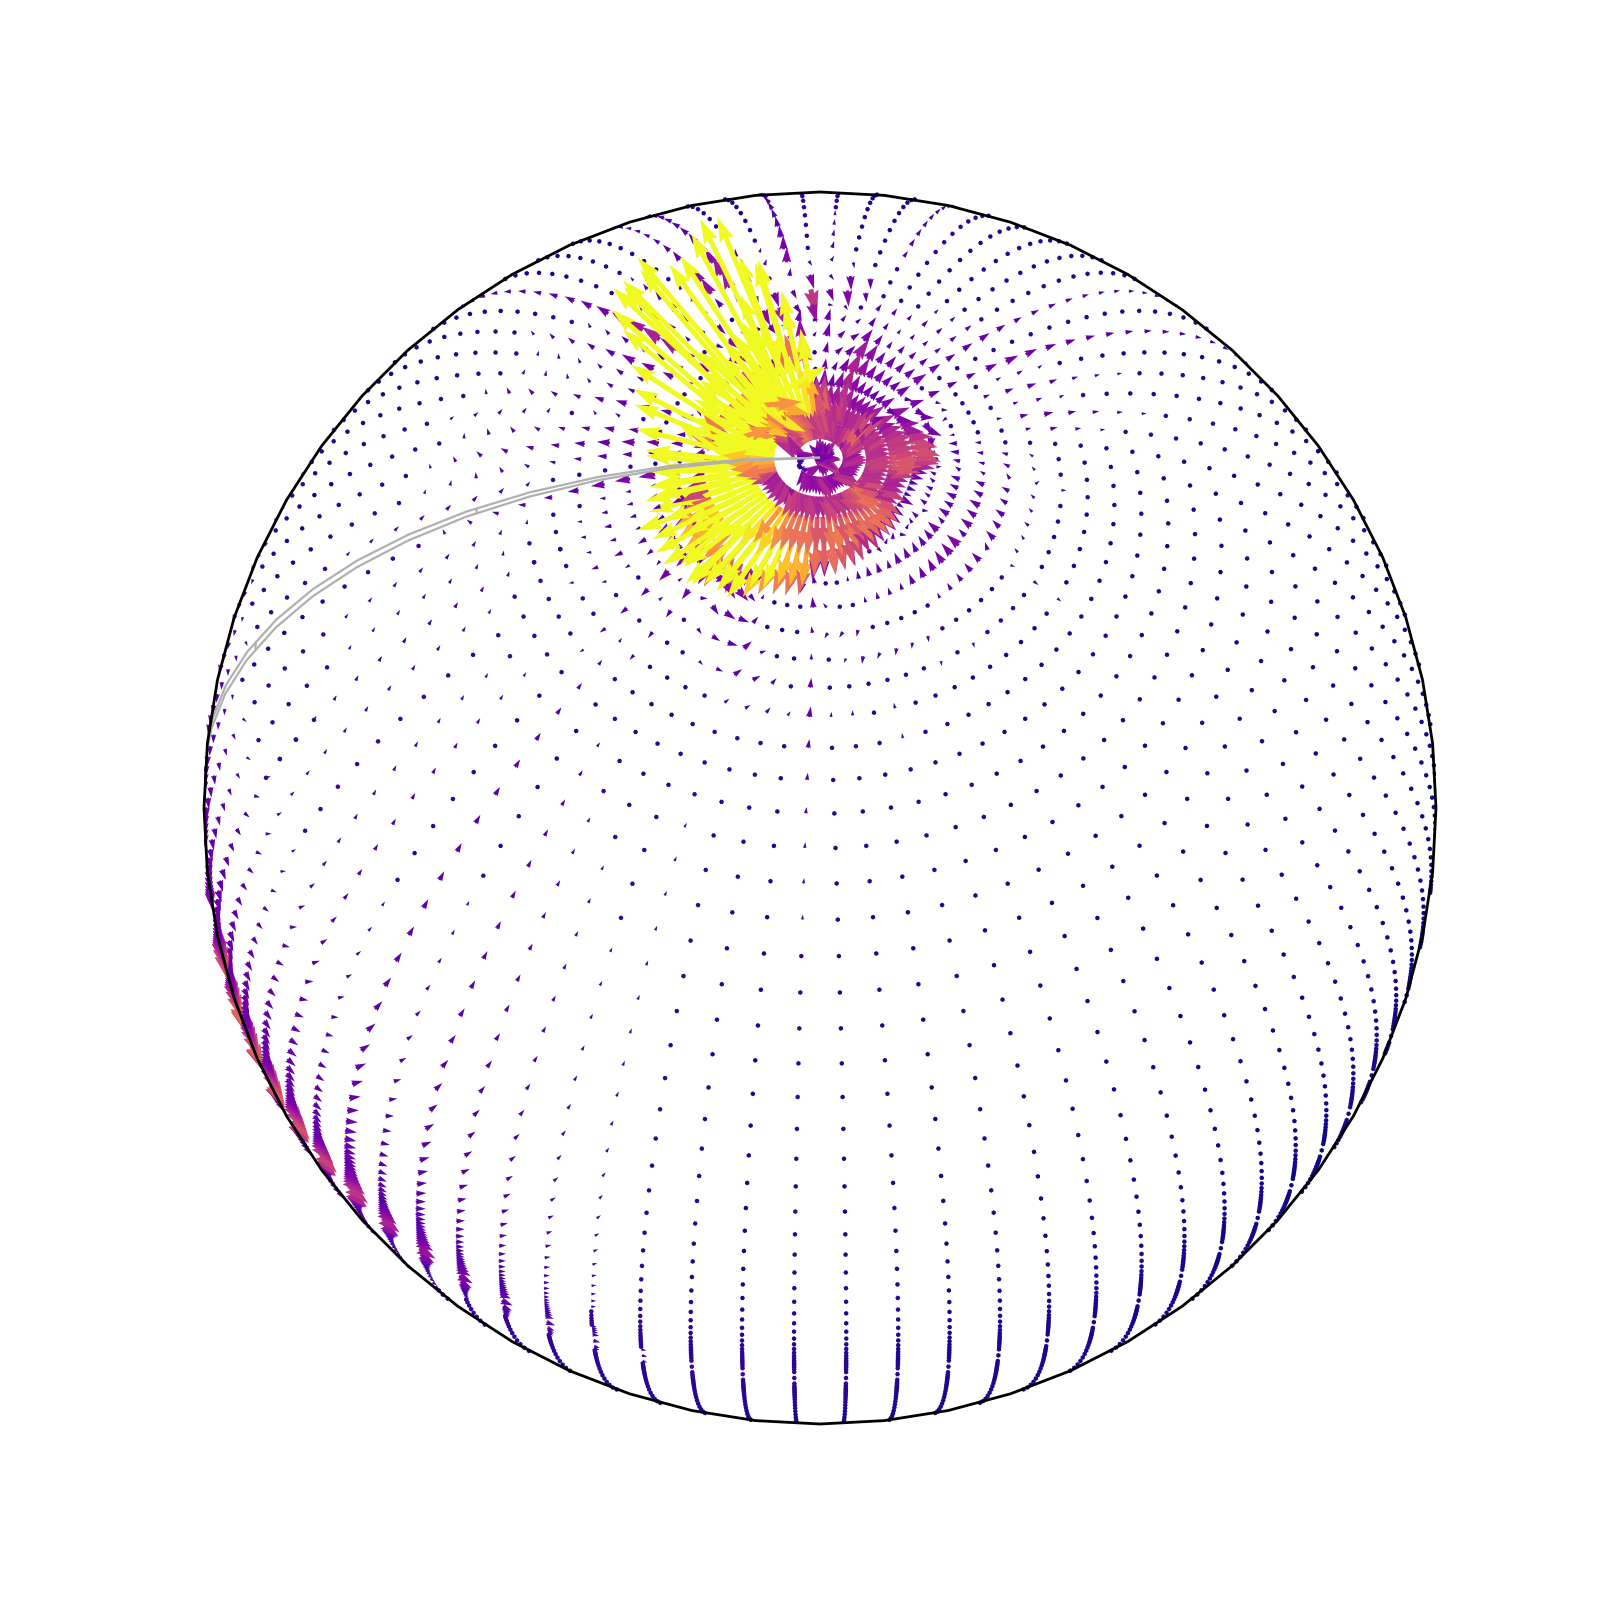

/glade/u/home/jrigler/Python_VEs/20190627_JRIGLER/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)


In [31]:
bbox = [-90, 270, -90, 90]
projection = ccrs.NearsidePerspective(central_latitude=60, central_longitude=90)
proj_data = ccrs.PlateCarree()

fig, ax_KQfield = plt.subplots(nrows=1, ncols=1,
                               figsize=(8, 8),
                               subplot_kw=dict(projection=projection))

# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = [.5, -.5, -.5]
yticks = [-90, -60, -30, 0, 30, 60, 90]
ax_KQfield.gridlines(xlocs=xticks, ylocs=yticks)

# need to transform mlat,mlon into geographic coordinates...
# for now, we just fake it so we can plot things nicely, but
# without any actual features
#ax_KQfield.add_feature(coast)
#ax_KQfield.add_feature(states, alpha=0.8)
#ax_KQfield.add_feature(countries)

# calculate magnitude of vectors
grid_KQmag = np.sqrt(Jphi_TIE_geo**2 + Jtheta_TIE_geo**2)

# store the angles for preservation when scaling lengths by logarithms
grid_KQangles = np.arctan2(-Jtheta_TIE_geo, Jphi_TIE_geo)

# force positive magnitudes to be >=1 so logs are not negative
# (non-linear scaling is problematic; we should probably scale,
#  or alter units, truncate below 1, then take logarithm)
uv_mag = np.log10(grid_KQmag+1)
uv_mag = grid_KQmag
KQPHI_log = uv_mag*np.cos(grid_KQangles)
KQLAM_log = uv_mag*np.sin(grid_KQangles)

# configure quiver plot view
#ax_KQfields[0].set_extent(bbox, proj_data)
normQ = mpl.colors.Normalize(vmin=.0, vmax=.15)
cmap = mpl.cm.plasma
KQscale = 0.5
arrow_width = 0.004

# meshgridded lons and lats
mlons = phi_TIE_geo * 180/np.pi
mlats = 90 - theta_TIE_geo * 180/np.pi

# plot vectors
Q_obs = ax_KQfield.quiver(
    mlons, mlats,
    KQPHI_log, KQLAM_log, grid_KQmag, 
    cmap=cmap, transform=proj_data,
    scale_units='inches', scale=KQscale/1, width=arrow_width,
    alpha=1., norm=normQ)
#fig.colorbar(Q_obs, ax=ax_KQfield)


In [61]:
# retrieve TIEGCM height-integrated currents; drop redundant
# longitudes, convert to GEO coordinates
x, y, z, dx, dy, dz = pyLTR.transform.SPHtoCAR(
    phi_TIE_mag,
    theta_TIE_mag,
    6500e3,
    dTIEGCM.read('KQPHI', time).T,
    -dTIEGCM.read('KQLAM', time).T,
    0.0 )

x, y, z = pyLTR.transform.MAGtoSM(x, y, z, time)
dx, dy, dz = pyLTR.transform.MAGtoSM(dx, dy, dz, time)

(phi_TIE_sm, theta_TIE_sm, rho_TIE_sm,
 Jphi_TIE_sm, Jtheta_TIE_sm, Jrho_TIE_sm) = pyLTR.transform.CARtoSPH(
    x, y, z, dx, dy, dz)


<IPython.core.display.Javascript object>


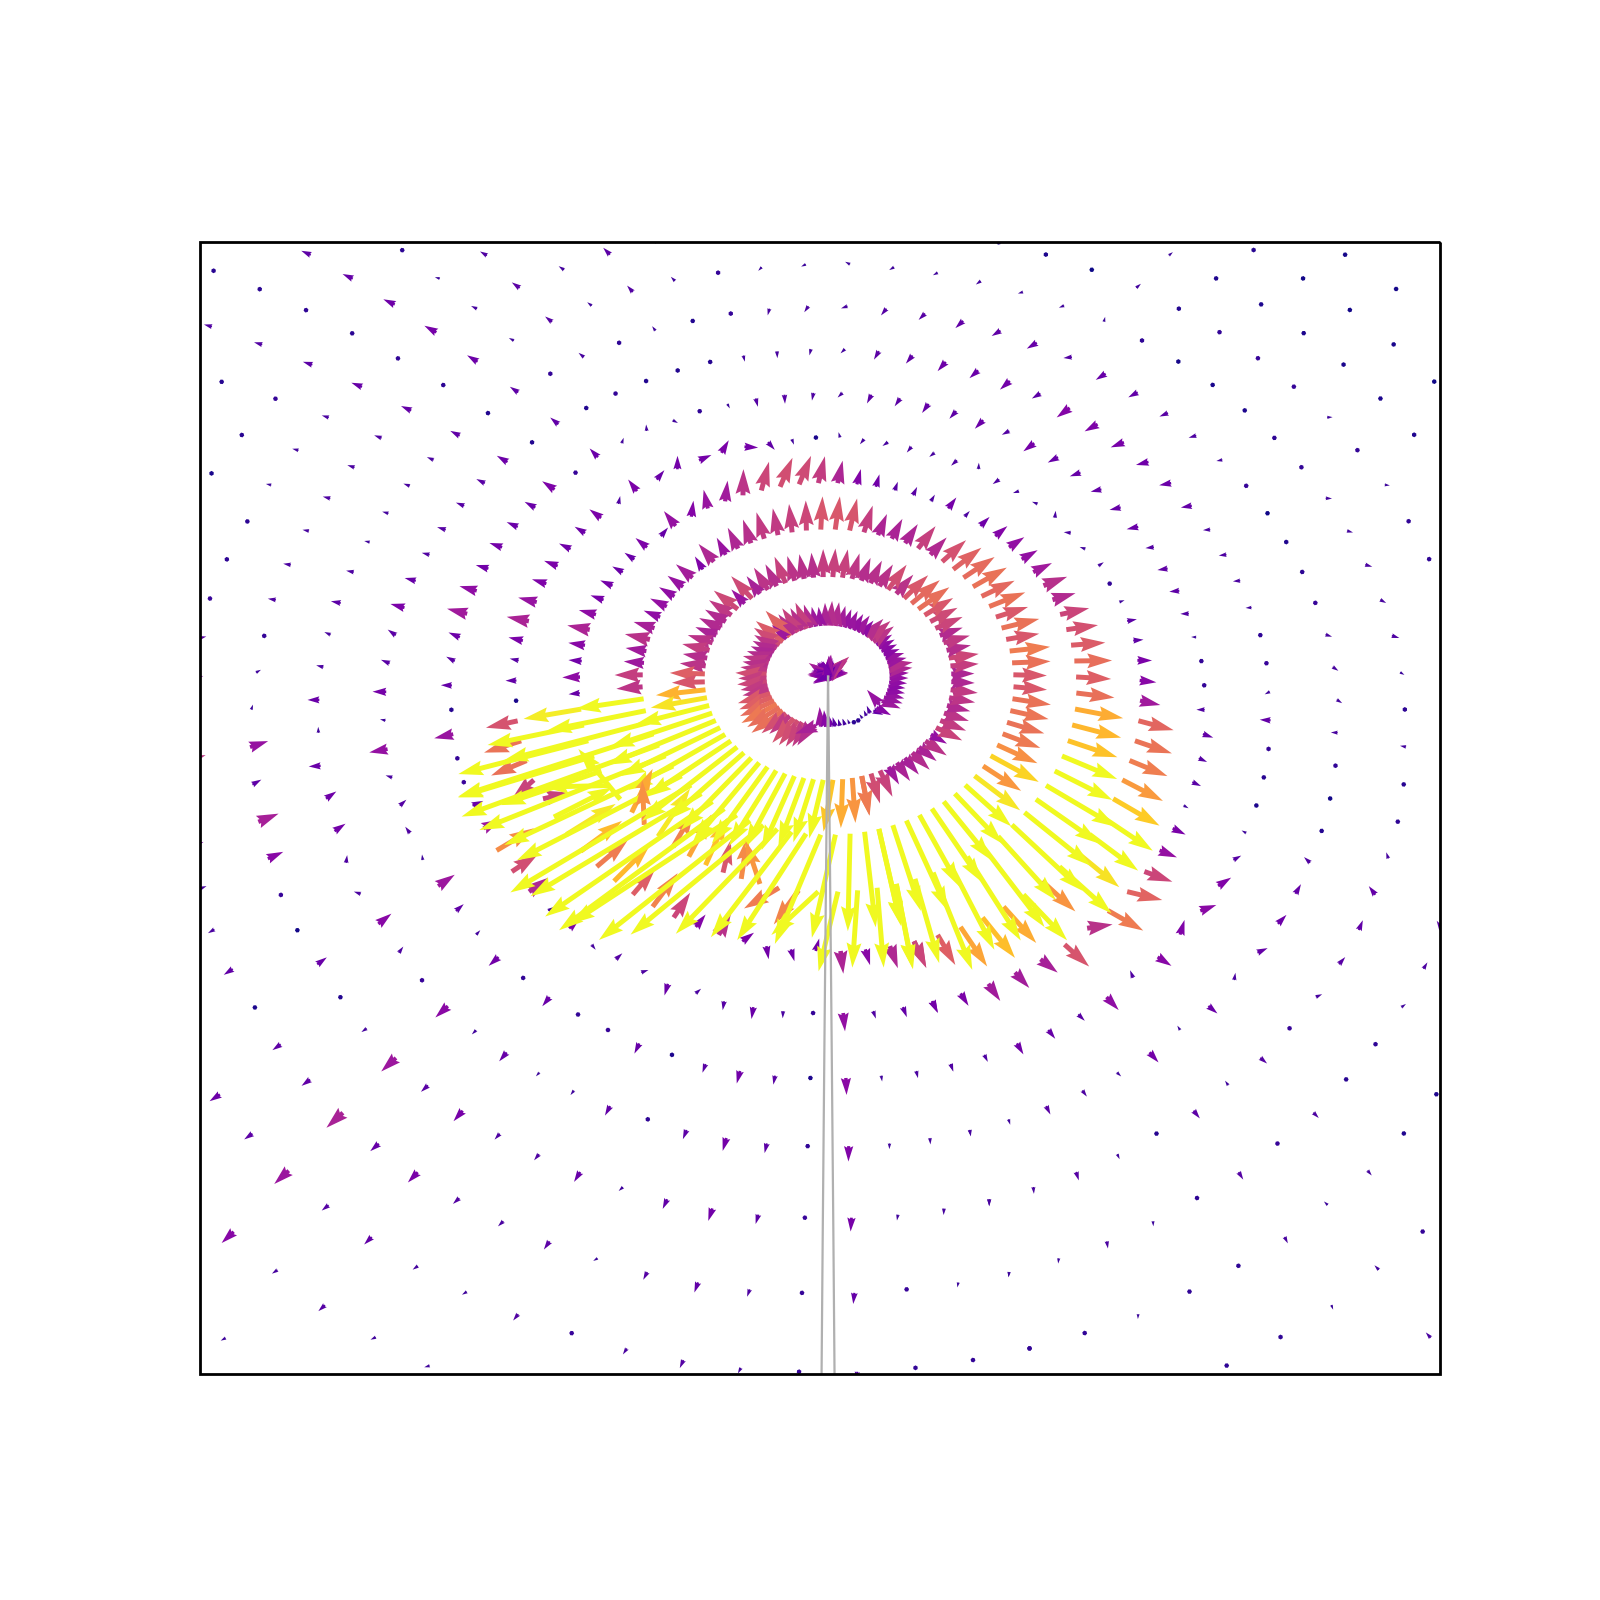

In [72]:
bbox = [-90, 270, -90, 90]
projection = ccrs.NearsidePerspective(central_latitude=60, central_longitude=0)
proj_data = ccrs.PlateCarree()

fig, ax_KQfield = plt.subplots(nrows=1, ncols=1,
                               figsize=(8, 8),
                               subplot_kw=dict(projection=projection))

# Define gridline locations and draw the lines using cartopy's built-in gridliner:
xticks = [.5, -.5, -.5]
yticks = [-90, -60, -30, 0, 30, 60, 90]
ax_KQfield.gridlines(xlocs=xticks, ylocs=yticks)

# need to transform mlat,mlon into geographic coordinates...
# for now, we just fake it so we can plot things nicely, but
# without any actual features
#ax_KQfield.add_feature(coast)
#ax_KQfield.add_feature(states, alpha=0.8)
#ax_KQfield.add_feature(countries)

# calculate magnitude of vectors
grid_KQmag = np.sqrt(Jphi_TIE_sm**2 + Jtheta_TIE_sm**2)

# store the angles for preservation when scaling lengths by logarithms
grid_KQangles = np.arctan2(-Jtheta_TIE_sm, Jphi_TIE_sm)

# force positive magnitudes to be >=1 so logs are not negative
# (non-linear scaling is problematic; we should probably scale,
#  or alter units, truncate below 1, then take logarithm)
uv_mag = np.log10(grid_KQmag+1)
uv_mag = grid_KQmag
KQPHI_log = uv_mag*np.cos(grid_KQangles)
KQLAM_log = uv_mag*np.sin(grid_KQangles)

# configure quiver plot view
#ax_KQfields[0].set_extent(bbox, proj_data)
normQ = mpl.colors.Normalize(vmin=.0, vmax=.15)
cmap = mpl.cm.plasma
KQscale = 0.5
arrow_width = 0.004

# meshgridded lons and lats
mlons = phi_TIE_sm * 180/np.pi
mlats = 90 - theta_TIE_sm * 180/np.pi

# plot vectors
Q_obs = ax_KQfield.quiver(
    mlons, mlats,
    KQPHI_log, KQLAM_log, grid_KQmag, 
    cmap=cmap, transform=proj_data,
    scale_units='inches', scale=KQscale/1, width=arrow_width,
    alpha=1., norm=normQ)
#fig.colorbar(Q_obs, ax=ax_KQfield)


<IPython.core.display.Javascript object>


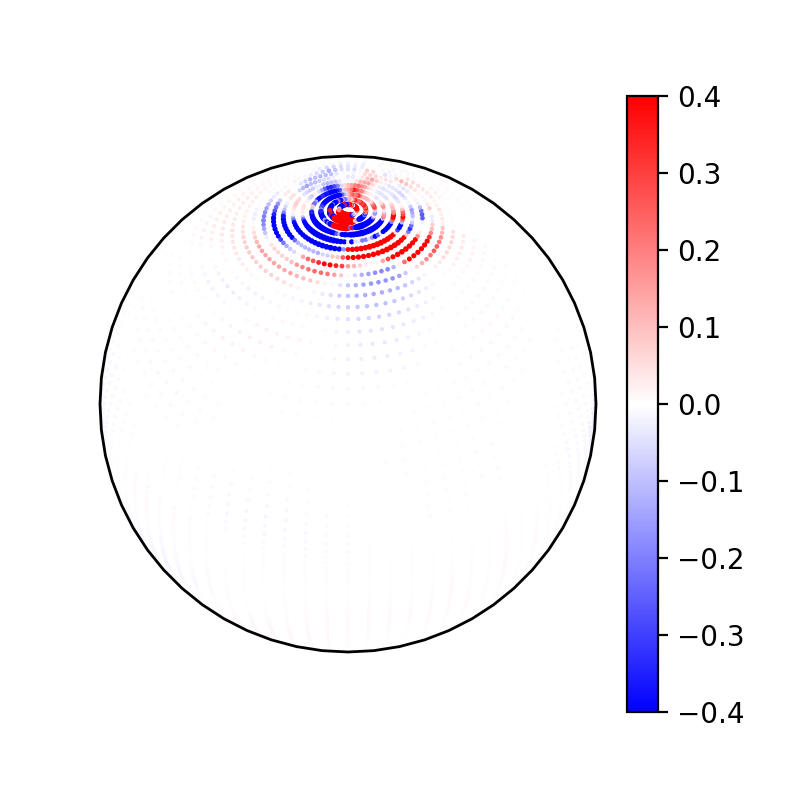

In [89]:
# meshgrid lons and lats
mlons, mlats = np.meshgrid(data_sech.mlon.values, 
                           data_sech.mlat.values)
phi = np.mod(360 + mlons.T, 360) * np.pi/180.
theta = (90 - mlats.T) * np.pi/180.
vphi = data_sech.KQPHI[0].values.T
vtheta = -data_sech.KQLAM[0].values.T

# 2D divergence of currents
div2D = pyLTR.Physics.MIXCalcs._div2d_sph(
    (vphi, vtheta),
    (phi, theta))
div2D[np.abs(div2D) > 1e12] = 0

# configure scatter plot view
bbox = [-90, 270, -90, 90]
projection = ccrs.NearsidePerspective(central_latitude=45, central_longitude=-90)
proj_data = ccrs.PlateCarree()
fig, ax_div2D = plt.subplots(figsize=(4,4),
                             subplot_kw=dict(projection=projection))
#ax_div2D.set_extent(bbox, proj_data)
normS = mpl.colors.Normalize(vmin=-4e-1, vmax=4e-1)
cmap = mpl.cm.bwr
S_obs = ax_div2D.scatter(
    mlons, mlats,
    c=-div2D.T,
    s=np.sqrt(np.abs(div2D.T))*1e-0,
    cmap=cmap, transform=proj_data,
    alpha=1., norm=normS)
fig.colorbar(S_obs, ax=ax_div2D)


<IPython.core.display.Javascript object>


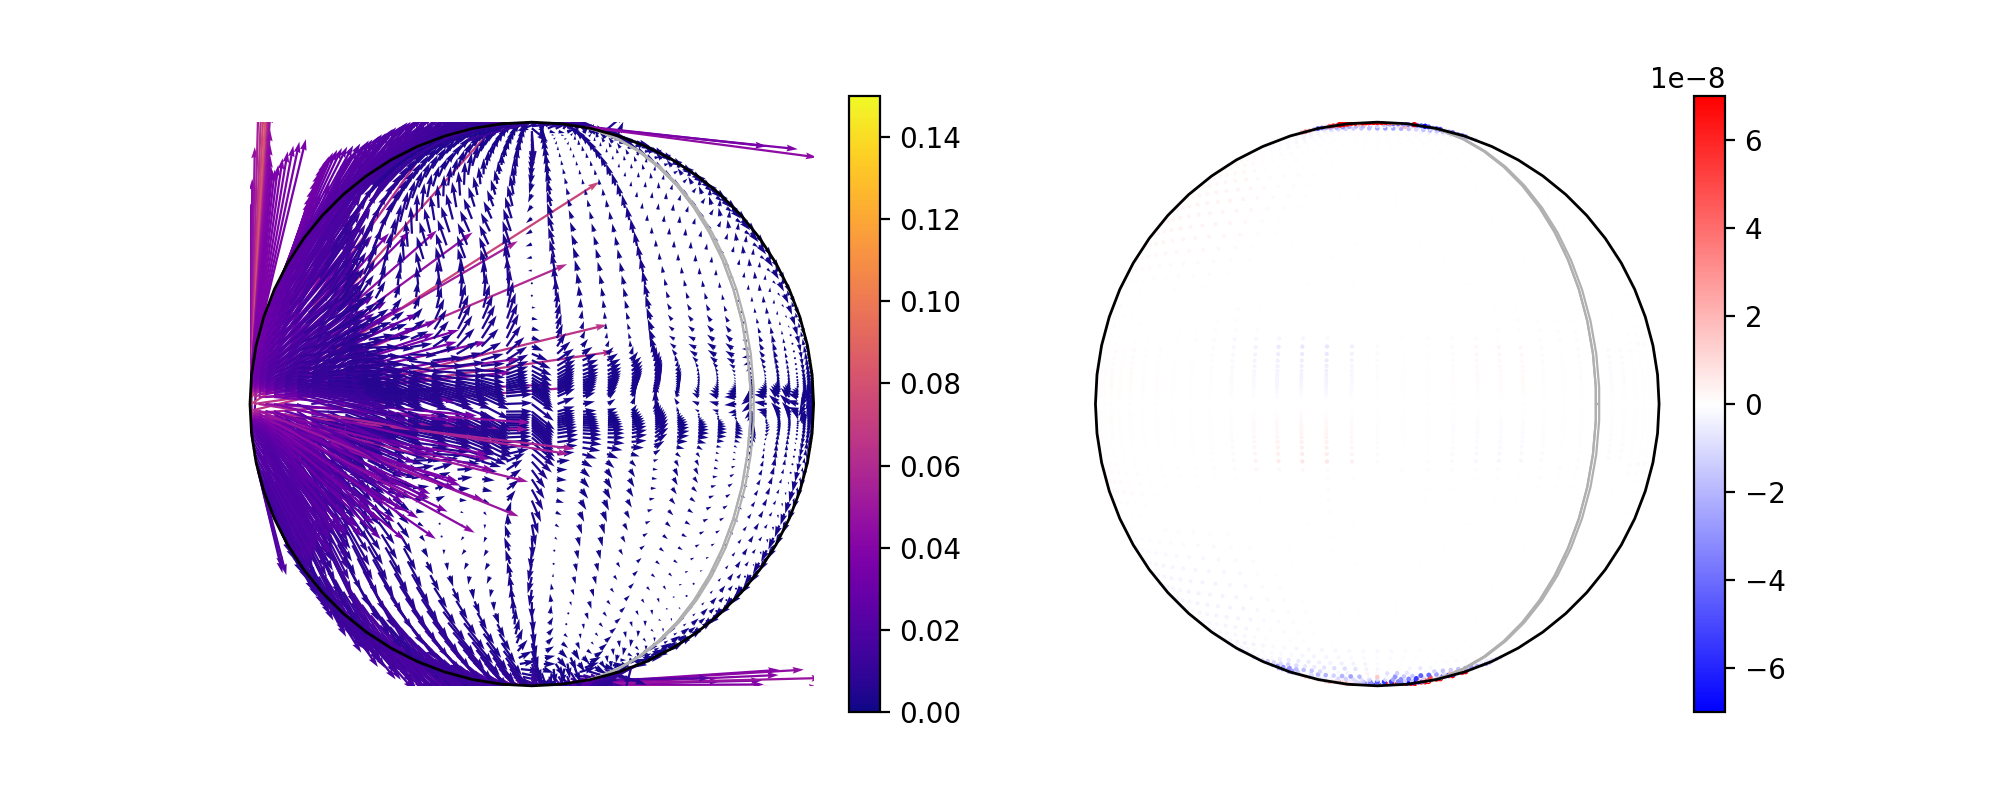

In [35]:

# 
# map config
#
bbox = [-90, 270, -90, 90]
projection = ccrs.NearsidePerspective(central_latitude=0, central_longitude=-45)
proj_data = ccrs.PlateCarree()

# loop over time steps
#for i in range(len(data_sech.KQPHI)):
for i in [0]:    
    fig, ax_KQfields = plt.subplots(nrows=1, ncols=2,
                                    figsize=(10, 4),
                                    subplot_kw=dict(projection=projection))

    # Define gridline locations and draw the lines using cartopy's built-in gridliner:
    xticks = [.5, -.5, -.5]
    yticks = [-90, -60, -30, 0, 30, 60, 90]
    ax_KQfields[0].gridlines(xlocs=xticks, ylocs=yticks)
    ax_KQfields[1].gridlines(xlocs=xticks, ylocs=yticks)

    ## need to transform mlat,mlon into geographic coordinates...
    ## for now, we just fake it so we can plot things nicely, but
    ## without any actual features
    # ax_Bfield.add_feature(coast)
    # ax_Bfield.add_feature(states, alpha=0.8)
    # ax_Bfield.add_feature(countries)

    # calculate magnitude of vectors
    grid_KQmag = np.sqrt(data_sech.KQPHI[i].values**2 + data_sech.KQLAM[i].values**2)

    # store the angles for preservation when scaling lengths by logarithms
    grid_KQangles = np.arctan2(data_sech.KQLAM[i].values, 
                           data_sech.KQPHI[i].values)
    
    # force positive magnitudes to be >=1 so logs are not negative
    # (non-linear scaling is problematic; we should probably scale,
    #  or alter units, truncate below 1, then take logarithm)
    uv_mag = np.log10(grid_KQmag+1)
    KQPHI_log = uv_mag*np.cos(grid_KQangles)
    KQLAM_log = uv_mag*np.sin(grid_KQangles)
    
    # configure quiver plot view
    #ax_KQfields[0].set_extent(bbox, proj_data)
    normQ = mpl.colors.Normalize(vmin=.0, vmax=.15)
    cmap = mpl.cm.plasma
    KQscale = 0.15
    arrow_width = 0.004
    
    # meshgrid lons and lats
    mlons, mlats = np.meshgrid(data_sech.mlon.values, data_sech.mlat.values)
    
    # plot vectors
    Q_obs = ax_KQfields[0].quiver(
        mlons, mlats,
        KQPHI_log, KQLAM_log, grid_KQmag, 
        cmap=cmap, transform=proj_data,
        scale_units='inches', scale=KQscale/10, width=arrow_width,
        alpha=1., norm=normQ)
    fig.colorbar(Q_obs, ax=ax_KQfields[0])
    
    
    JQR = data_sech.JQR[i].values
    
    # configure scatter plot view
    #ax_KQfields[1].set_extent(bbox, proj_data)
    normS = mpl.colors.Normalize(vmin=-7e-8, vmax=7e-8)
    cmap = mpl.cm.bwr
    S_obs = ax_KQfields[1].scatter(
        mlons, mlats,
        c=JQR,
        s=np.sqrt(np.abs(JQR))*3e3,
        cmap=cmap, transform=proj_data,
        alpha=1., norm=normS)
    fig.colorbar(S_obs, ax=ax_KQfields[1])
    
    

In [41]:
# meshgrid lons and lats
mlats, mlons = np.meshgrid(data_sech.mlat.values, data_sech.mlon.values)

print(mlons.shape)
print(mlons)
print(mlats.shape)
print(90-mlats)



(81, 97)
[[-180.  -180.  -180.  ... -180.  -180.  -180. ]
 [-175.5 -175.5 -175.5 ... -175.5 -175.5 -175.5]
 [-171.  -171.  -171.  ... -171.  -171.  -171. ]
 ...
 [ 171.   171.   171.  ...  171.   171.   171. ]
 [ 175.5  175.5  175.5 ...  175.5  175.5  175.5]
 [ 180.   180.   180.  ...  180.   180.   180. ]]
(81, 97)
[[1.80000000e+02 1.78123829e+02 1.76238636e+02 ... 3.76136407e+00
  1.87617076e+00 1.42108547e-14]
 [1.80000000e+02 1.78123829e+02 1.76238636e+02 ... 3.76136407e+00
  1.87617076e+00 1.42108547e-14]
 [1.80000000e+02 1.78123829e+02 1.76238636e+02 ... 3.76136407e+00
  1.87617076e+00 1.42108547e-14]
 ...
 [1.80000000e+02 1.78123829e+02 1.76238636e+02 ... 3.76136407e+00
  1.87617076e+00 1.42108547e-14]
 [1.80000000e+02 1.78123829e+02 1.76238636e+02 ... 3.76136407e+00
  1.87617076e+00 1.42108547e-14]
 [1.80000000e+02 1.78123829e+02 1.76238636e+02 ... 3.76136407e+00
  1.87617076e+00 1.42108547e-14]]


In [60]:
print(data_sech.KQPHI[0].values.shape)
print(data_sech.KQPHI[0].values[:,(0,-1)])
print()
print(data_sech.KQLAM[0].values.shape)
print(data_sech.KQLAM[0].values[:,(0,-1)])


(97, 81)
[[ 0.01866176  0.01866176]
 [ 0.12396163  0.12396163]
 [ 0.06720232  0.06720232]
 [ 0.03747923  0.03747923]
 [ 0.01057102  0.01057102]
 [ 0.01569548  0.01569548]
 [ 0.02478797  0.02478797]
 [ 0.02651775  0.02651775]
 [ 0.02242018  0.02242018]
 [ 0.01889756  0.01889756]
 [ 0.01674029  0.01674029]
 [ 0.01379351  0.01379351]
 [ 0.0116458   0.0116458 ]
 [ 0.00909814  0.00909814]
 [ 0.00676091  0.00676091]
 [ 0.00440971  0.00440971]
 [ 0.00244004  0.00244004]
 [ 0.00143813  0.00143813]
 [ 0.0013644   0.0013644 ]
 [ 0.00168448  0.00168448]
 [ 0.00209228  0.00209228]
 [ 0.00222068  0.00222068]
 [ 0.00188059  0.00188059]
 [ 0.00126737  0.00126737]
 [ 0.00066163  0.00066163]
 [ 0.00025749  0.00025749]
 [ 0.00014153  0.00014153]
 [ 0.0003221   0.0003221 ]
 [ 0.00076162  0.00076162]
 [ 0.00140441  0.00140441]
 [ 0.00217837  0.00217837]
 [ 0.00302553  0.00302553]
 [ 0.00386004  0.00386004]
 [ 0.004558    0.004558  ]
 [ 0.00503632  0.00503632]
 [ 0.00535635  0.00535635]
 [ 0.00563336  0.00

In [29]:
whos

Variable            Type                       Data/Info
--------------------------------------------------------
cartopy             module                     <module 'cartopy' from '/<...>ges/cartopy/__init__.py'>
ccrs                module                     <module 'cartopy.crs' fro<...>packages/cartopy/crs.py'>
cfeature            module                     <module 'cartopy.feature'<...>opy/feature/__init__.py'>
cm_RedGreen         LinearSegmentedColormap    <matplotlib.colors.Linear<...>object at 0x2b3593341cc0>
coast               NaturalEarthFeature        <cartopy.feature.NaturalE<...>object at 0x2b3586ffe400>
countries           NaturalEarthFeature        <cartopy.feature.NaturalE<...>object at 0x2b3593341b70>
data_sech           Dataset                    <xarray.Dataset>\nDimensi<...>ay hour min by delta_mins
datetime            module                     <module 'datetime' from '<...>b/python3.6/datetime.py'>
gridList            list                       n=2555
lakes   